In [1]:
import sys
import os
import copy

# Absolute path to your module's directory
module_path = os.path.abspath('/localscratch/zippoema/git/HPA/src/')
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import hpa.cluster as hpacl  # Now this should work
import hpa.util as hpau  # Now this should work
import hpa.plots as hpapl

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:160: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import gsd.hoomd 
from MDAnalysis.analysis import distances



In [3]:
path_200 = '/localscratch/zippoema/project_ness/simulations/200-tdp43_CAL3/'
path = '/localscratch/zippoema/project_ness/simulations/'
path_ss = '/localscratch/zippoema/project_ness/simulations/phase_diagram/search_steadystate/'
path_work = '/localscratch/zippoema/working_dir/'
path_an_200 = '/localscratch/zippoema/project_ness/analysis/200-tdp43_CAL3/'
path_an_dp = '/localscratch/zippoema/project_ness/analysis/condensate_dephospho/'
path_dp = '/localscratch/zippoema/project_ness/simulations/condensate_dephospho/'
path_struct = '/localscratch/zippoema/project_ness/simulations/condensate_struct_CAL3/'
path_ness = '/localscratch/zippoema/project_ness/simulations/simple-ness_CAL3/'
path_fix = '/localscratch/zippoema/project_ness/simulations/ness_1-ck1d_1-pp3/'

### Center trajectory

In [23]:
hpau.center_trajectory_z(path_struct+'equilibrium/sim_eq_slab_400-tdp43-lcd_5-ck1d-open/sim_eq_slab_400-tdp43-lcd_5-com-ck1d-open_CAL3_dump.gsd',
                       path_struct+'equilibrium/sim_eq_slab_400-tdp43-lcd_5-ck1d-open/sim_eq_slab_400-tdp43-lcd_5-com-ck1d-open_CAL3_dump_centered.gsd',
                       group=[i for i in range(61600)], cluster=True, cutoff=2.5)
                       

Centering trajectory along z: 100%|███████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:39<00:00, 12.64it/s]


In [7]:
for i in range(4,11):
    hpau.center_trajectory(path_dp+f'sim_200-tdp43-lcd-2800pser_5-pp3/sim{i}_200-tdp43-lcd-2800pser_5-com-pp3_CAL3_5us_dump.gsd', 
                           path_dp+f'sim_200-tdp43-lcd-2800pser_5-pp3/sim{i}_200-tdp43-lcd-2800pser_5-com-pp3_CAL3_5us_dump_centered.gsd', 
                           group=[i for i in range(30800)], cluster=True, cutoff=2.5)

Centering trajectory: 100%|█████████████████████████████████████████| 2500/2500 [02:39<00:00, 15.69it/s]


In [7]:
!rm /localscratch/zippoema/project_ness/simulations/sim_200-tdp43-lcd_CAL3/therm*_200-tdp43-lcd_CAL3_centered1.gsd

### Unwrap trajectory

In [10]:
traj_in = gsd.hoomd.open('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_dump.gsd', 'rb')
traj_out = gsd.hoomd.open('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_dump_unwrapped.gsd', 'wb')

for frame in tqdm(traj_in):
    # Copy the frame to preserve all other information
    new_frame = gsd.hoomd.Frame()
    new_frame.configuration = frame.configuration
    new_frame.particles = frame.particles

    # Box dimensions
    Lx, Ly, Lz = frame.configuration.box[:3]

    # Unwrap positions using image flags
    pos = frame.particles.position.copy()
    image = frame.particles.image.copy()   # integer triplets
    pos[:, 0] += image[:, 0] * Lx
    pos[:, 1] += image[:, 1] * Ly
    pos[:, 2] += image[:, 2] * Lz

    # Store unwrapped positions
    new_frame.particles.position = pos

    # Write to output
    traj_out.append(new_frame)

traj_out.close()

### Modify particle positions

In [12]:
for i in [1]:
    frame_pos = gsd.hoomd.open(path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_end.gsd', mode='rb')[0]
    frame_compl = gsd.hoomd.open(path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_12-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_12-com-pp3_CAL3_search_start.gsd', mode='rb')[0]
    hpau.modify_particles_position(frame_compl, frame_pos, id_init_pos=0, id_end_pos=36654, 
                                   save=path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_12-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_12-com-pp3_CAL3_search_start1.gsd')


In [13]:
frame_pos = gsd.hoomd.open(path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_end.gsd', mode='rb')[0]
frame_compl = gsd.hoomd.open(path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_12-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_12-com-pp3_CAL3_search_start1.gsd', mode='rb')[0]

hpau.modify_particles_typeid(frame_compl, frame_pos, id_init_tid=0, id_end_tid=30800,
                               save=path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_12-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_12-com-pp3_CAL3_search_start.gsd')


In [25]:
frame_pos = gsd.hoomd.open(path_struct+'equilibrium/sim_eq_slab_400-tdp43-lcd_5-ck1d-open/sim_eq_slab_400-tdp43-lcd_5-com-ck1d-open_CAL3_start.gsd', mode='rb')[0]
frame_compl = gsd.hoomd.open(path_work+'condensate_struct_CAL3/sim_eq_slab_400-tdp43-lcd_5-pp3/sim_eq_slab_400-tdp43-lcd_5-com-pp3_CAL3_start_lattice.gsd', mode='rb')[0]
snap = copy.deepcopy(frame_compl)
snap.configuration = frame_pos.configuration
tdp43_cond_n = 154*400
'''
snap.particles.typeid[:tdp43_cond_n] = frame_pos.particles.typeid[:tdp43_cond_n]
snap.particles.charge[:tdp43_cond_n] = frame_pos.particles.charge[:tdp43_cond_n]
snap.particles.mass[:tdp43_cond_n] = frame_pos.particles.mass[:tdp43_cond_n]
'''
snap.particles.velocity[:tdp43_cond_n] = frame_pos.particles.velocity[:tdp43_cond_n]
snap.particles.image[:tdp43_cond_n] = frame_pos.particles.image[:tdp43_cond_n]

snap.particles.position[:tdp43_cond_n] = frame_pos.particles.position[:tdp43_cond_n]
snap.particles.position[:tdp43_cond_n,2] -= np.mean(frame_pos.particles.position[:tdp43_cond_n,2], axis=0)
pp3_pos = snap.particles.position[tdp43_cond_n:]
for npp3 in range(5):
    pp3_pos[527*npp3:527*(npp3+1)] -= np.mean(frame_compl.particles.position[tdp43_cond_n+527*npp3:tdp43_cond_n+527*(npp3+1)], axis=0)
    pp3_pos[527*npp3:527*(npp3+1)] += np.array([-(-1)**npp3*(npp3%3)*4, (-1)**npp3*(npp3%2)*6, -(-1)**npp3*(37+npp3*7)])

snap.particles.position[tdp43_cond_n:] = pp3_pos

with gsd.hoomd.open(path_work+'condensate_struct_CAL3/sim_eq_slab_400-tdp43-lcd_5-pp3/shtherm_eq_slab_400-tdp43-lcd_5-com-pp3_CAL3_start.gsd', mode='wb') as f:
    f.append(snap)


In [67]:
for i in [2500]:
    frame_compl = gsd.hoomd.open(path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_lattice.gsd', mode='rb')[0]
    frame_pos = gsd.hoomd.open(path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-{i}pSer_5-ck1d-open_hps-cp-r30.gsd', mode='rb')[0]
    hpau.modify_particles_position(frame_compl, frame_pos, id_end_compl=30800, id_end_pos=30800,
                                   save=path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-{i}pSer_2-com-ck1d-open_10-com-pp3_CAL3_shorttherm_start.gsd')

In [42]:
for i in [2500]:
    frame_pos = gsd.hoomd.open(path_work+'no_driving_slab/sim_eq_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_eq_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump.gsd', mode='rb')[-1]
    frame_compl = gsd.hoomd.open('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/snap_p-tdp43_start.gsd', mode='rb')[0]
    hpau.modify_particles_typeid(frame_compl, frame_pos, id_init_tid=18634, id_end_tid=18787,
                                   save='/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_start.gsd')

## Create distance trajectory

100%|█████████████████████████████████| 400000/400000 [01:45<00:00, 3807.67it/s]


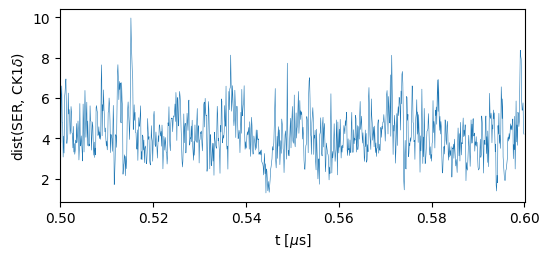

100%|█████████████████████████████████| 400000/400000 [01:39<00:00, 4031.55it/s]


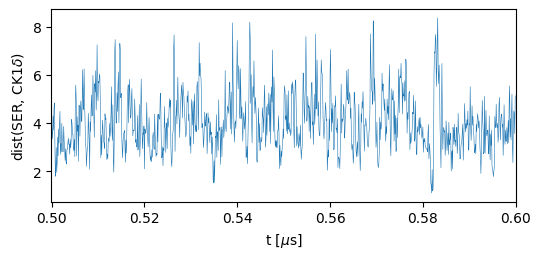

100%|█████████████████████████████████| 400000/400000 [01:28<00:00, 4496.13it/s]


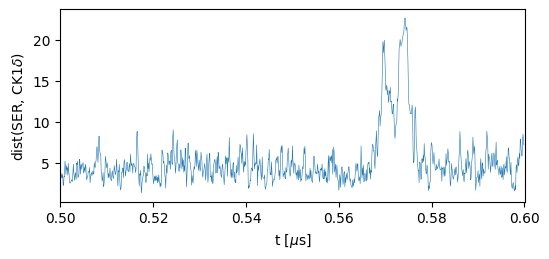

In [23]:
rdump = 5
rigid = ''
dmu = 2.5
temp='200K_'

for s in range(1,4):
    d = hpau.create_distance_file(path_ness+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{temp}{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{temp}{rdump}k_20us_dump.gsd', 
                                         id1=[300,301,302], id2=[i for i in range(154)], mean1=True, therm=0)
    np.savetxt(path_ness+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{temp}{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{temp}{rdump}k_20us_dist.txt', d)
    hpapl.plot_dist(d,part_id=5,start=5000,end=6000)

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/MDAnalysis/coordinates/GSD.py:263: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = gsd.fl.open(name=name,
100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [01:06<00:00, 2999.63it/s]


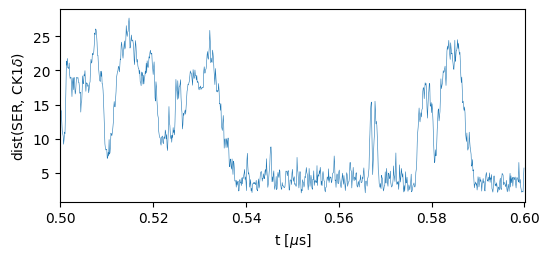

100%|██████████████████████████████████████████████████████████████████████████| 200000/200000 [08:33<00:00, 389.82it/s]


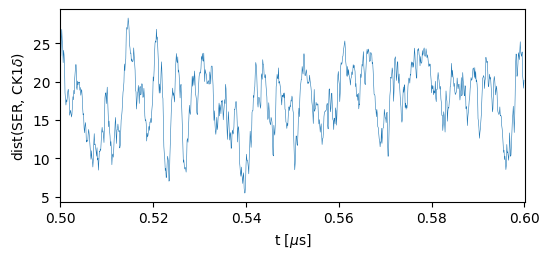

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [02:24<00:00, 1388.64it/s]


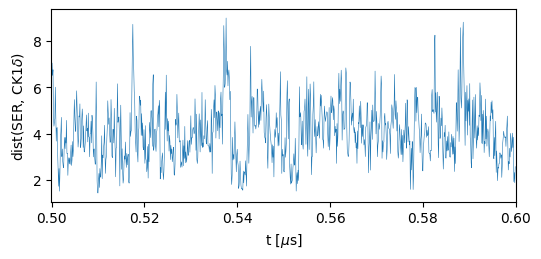

In [7]:
for s in range(1,4):
    d = hpau.create_distance_file(path_fix+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_sp_repel/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_CAL3_sp_repel_200K_5k_dump.gsd', 
                                         id1=[300,301,302], id2=[i for i in range(154)], mean1=True, therm=0)
    tmp = hpau.create_distance_file(path_fix+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_sp_repel/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_CAL3_sp_repel_200K_5k_dump.gsd', 
                                         id1=[445+92,445+94,445+120,445+152,445+283], id2=[i for i in range(154)], mean1=True, therm=0)
    d = np.append(d, tmp, axis=1)
    np.savetxt(path_fix+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_sp_repel/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_CAL3_sp_repel_200K_5k_dist.txt', d)
    hpapl.plot_dist(d,part_id=5,start=5000,end=6000)

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:42<00:00, 4654.27it/s]


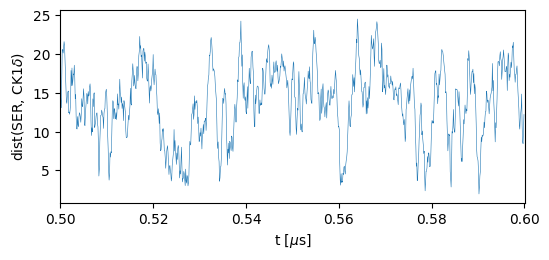

100%|█████████████████████████████████████████████████████████| 200000/200000 [01:00<00:00, 3325.35it/s]


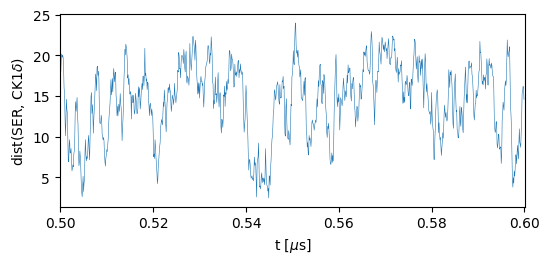

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:39<00:00, 5035.83it/s]


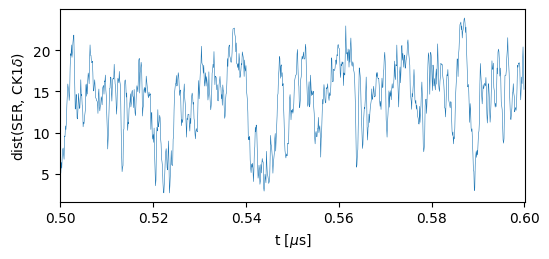

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:41<00:00, 4788.33it/s]


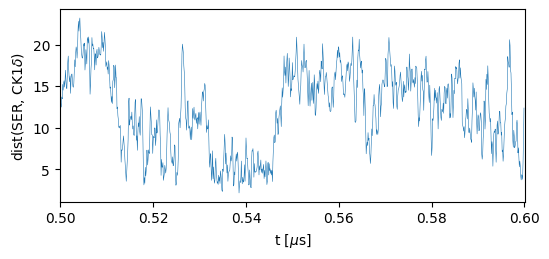

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:39<00:00, 5019.90it/s]


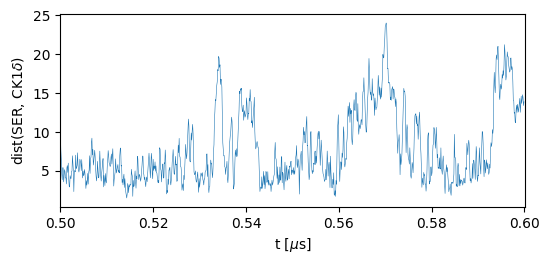

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:40<00:00, 4917.04it/s]


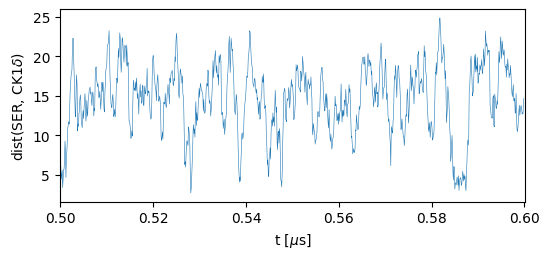

100%|█████████████████████████████████████████████████████████| 200000/200000 [01:00<00:00, 3280.36it/s]


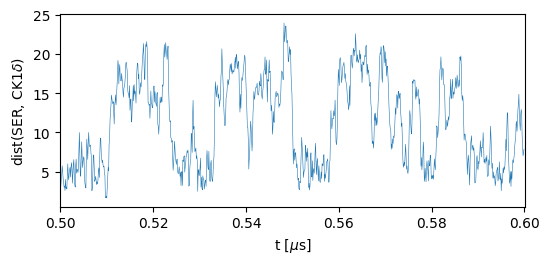

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:42<00:00, 4752.80it/s]


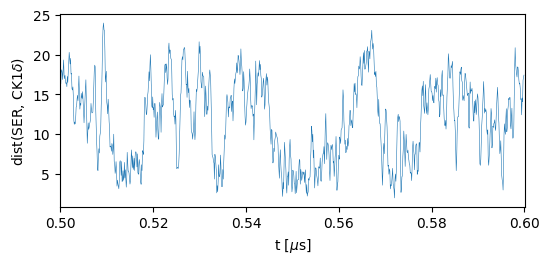

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:40<00:00, 4915.90it/s]


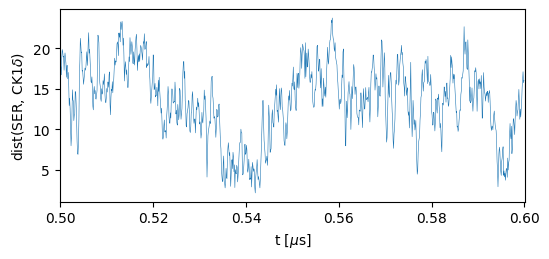

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:38<00:00, 5193.38it/s]


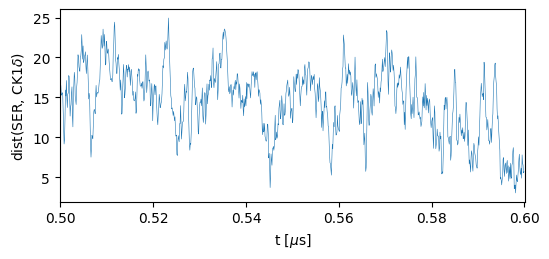

In [7]:
rdump = 5
rigid = 'rigid-'
dmu = 15
path_mc = f'/localscratch/zippoema/working_dir/tests/test_MC_kinetic/'
for s in range(11,21):
    d = hpau.create_distance_file(path_mc+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k_MCkin/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_MCkin_dump.gsd', 
                                     id1=[300,301,302], id2=[i for i in range(154)], mean1=True, therm=0)
    np.savetxt(path_mc+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k_MCkin/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_MCkin_dist.txt', d)
    hpapl.plot_dist(d,part_id=5,start=5000,end=6000)

In [8]:
d = hpau.create_distance_file(path_work+f'ness_1-tdp43-lcd_1-ck1d-open_MC_kin/sim_ser19_dmu-5_1-tdp43-5pser_1-ck1d-open_200K_5k_MC_kin/sim4_ser19_dmu-5_1-tdp43-5pser_com-ck1d-open_CAL3_200K_5k_MC_kin_dump.gsd', 
                                     id1=[300,301,302], id2=[i for i in range(154)], mean1=True, therm=0)
np.savetxt(path_work+f'ness_1-tdp43-lcd_1-ck1d-open_MC_kin/sim_ser19_dmu-5_1-tdp43-5pser_1-ck1d-open_200K_5k_MC_kin/sim4_ser19_dmu-5_1-tdp43-5pser_com-ck1d-open_CAL3_200K_5k_MC_kin_dist.txt', d)
hpapl.plot_dist(d,part_id=5,start=5000,end=6000)

OSError: Failed to load from the topology file /localscratch/zippoema/working_dir/ness_1-tdp43-lcd_1-ck1d-open_MC_kin/sim_ser19_dmu-5_1-tdp43-5pser_1-ck1d-open_200K_5k_MC_kin/sim4_ser19_dmu-5_1-tdp43-5pser_com-ck1d-open_CAL3_200K_5k_MC_kin_dump.gsd with parser <class 'MDAnalysis.topology.GSDParser.GSDParser'>.
Error: [Errno 9] Bad file descriptor: '/localscratch/zippoema/working_dir/ness_1-tdp43-lcd_1-ck1d-open_MC_kin/sim_ser19_dmu-5_1-tdp43-5pser_1-ck1d-open_200K_5k_MC_kin/sim4_ser19_dmu-5_1-tdp43-5pser_com-ck1d-open_CAL3_200K_5k_MC_kin_dump.gsd'